# Índice

1. [Desarrollo](#Desarrollo)
   
   a. [Cargamos los datos](#Cargamos-los-datos)
   
   b. [Estudio de los datos](#Estudio-de-los-datos)

   c. [Clustering](#Clustering)

   d. [Representación-de-los-clusters](#Representación-de-los-clusters)

   e. [Evaluación cuantitativa del clustering](#Evaluación-cuantitativa-del-clustering)

   f. [Selección del número de clusters](#Selección-del-número-de-clusters)

   g. [Asignación de un cluster a una nueva instancia](#Asignación-de-un-cluster-a-una-nueva-instancia)

   h. [Determinar la dimensión óptima de reducción](#Determinar-la-dimensión-óptima-de-reducción)

   i. [Reducción PCA y clustering](#Reducción-PCA-y-clustering)
   
3. [Respuestas](#Respuestas)

# Desarrollo

## Cargamos los datos

(archivo *mnist_train.csv*)

Importamos el dataset de MNIST. Usamos los archivos 
- train-images.idx3-ubyte
- train-labels.idx1-ubyte

Necesitamos convertir la extensión de MNIST a csv, por lo que usamos la siguiente [función](https://github.com/egcode/MNIST-to-CSV) (he editado un poco el código del link para añadir los nombres de las columnas)

In [80]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    f.close()
    l.close()
    
    # Fila con los nombres de las columnas del csv
    # El número de columnas es 784 (n_pixels) y la columna de los labels
    o = open(outf, "w")
    linea = "label"
    for i in range(0, 784):
        linea += f", p{i}"

    o.write(linea+"\n") # Escribimos la primera línea en el archivo de salida
    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")

    o.close()


In [ ]:
convert("train-images.idx3-ubyte", "train-labels.idx1-ubyte",
"mnist_train.csv", 60000)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

train = pd.read_csv('mnist_train.csv')
train.head() # Mostramos las 5 primeras líneas para hacernos una idea de la forma de nuestros datos

,label,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p774,p775,p776,p777,p778,p779,p780,p781,p782,p783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Estudio de los datos

In [3]:
import math

train.info() # Mostramos información genérica sobre el conjunto de datos
resol = math.sqrt(784) # Calculamos la resolución de la imagen
print(f"La resolución de las imágenes es de {resol} píxeles")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to  p783
dtypes: int64(785)
memory usage: 359.3 MB
La resolución de las imágenes es de 28.0 píxeles


In [2]:
# Separamos los subconjuntos X e Y: 
# x contendrá los datos para el clustering e y los labels ("clases reales")
y_train = train['label'].copy()

train.drop('label', axis=1, inplace=True)
x_train = train

In [5]:
# Mostramos el número de instancias real de cada clase
y_train.value_counts().sort_index()

label
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64

<BarContainer object of 10 artists>

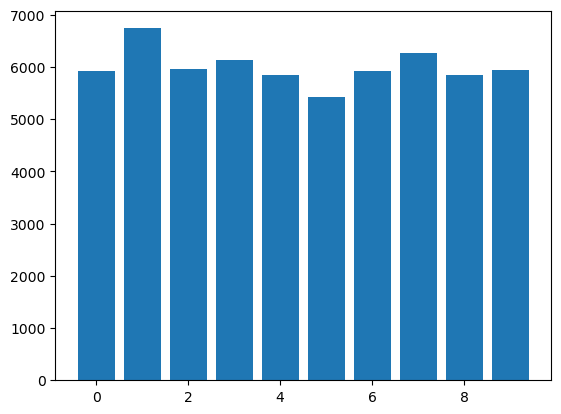

In [3]:
# Hacemos una grafica del numero de instancias reales por clase
from matplotlib import pyplot as plt
plt.bar(y_train.value_counts().index, y_train.value_counts())

In [25]:
# Función para visualizar una instancia (imagen 28*28)
def visualize(i, X, Y):
    instancia = X.iloc[i] # selecionamos los datos de una instancia i
    plt.imshow(instancia.values.reshape(28, 28))
    print('label', Y.iloc[i])

label 2


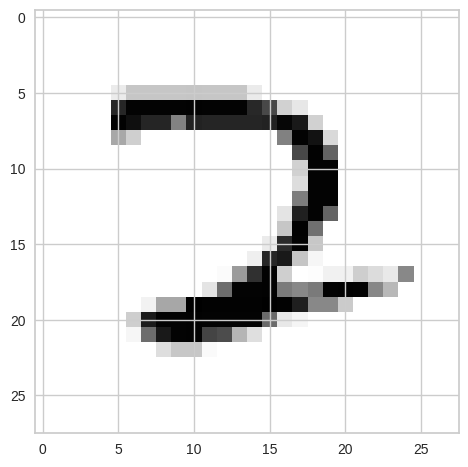

In [26]:
# Visualizamos una instancia cualquiera
visualize(530, x_train, y_train)

Con esta información podemos concluir lo siguiente:
1. Tenemos 60000 instancias de imágenes de números entre 0 y 9 escritos a mano.
2. Al tratarse de imágenes y sabiendo que la primera columna del train son los labels, podemos deducir que estamos trabajando con imágenes de 28x28 pixels.
3. El número de instancias de cada clase no es el mismo aunque sí es similar

## Clustering

In [8]:
from sklearn.cluster import KMeans
n_clusters = 10 # Número de labels o clusters a crear sobre el conjunto de datos
n_inicializaciones = 10 # Número de inicializaciones con diferentes centroides aleatorios

kmeans = KMeans(n_clusters, n_init=n_inicializaciones, random_state=0)
kmeans.fit(x_train)

# Obtenemos los labels del cluster para el subconjunto x_train (las imágenes)
kmeansLabels = kmeans.predict(x_train)

## Representación de los clusters

Para representar los clusters es necesario realizar una reducción de las dimensiones de los datos ya que resultaría muy complicado representar utilizando 784 dimensiones.
Por ellos vamos a hacer uso de dos técnicas de reducción diferentes: t-SNE y PCA

**t-SNE**

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE().fit_transform(x_train)

**PCA**

In [9]:
from sklearn.decomposition import PCA

print('Dimensiones originales: ', x_train.shape)
# Reducir las dimensiones para visualizarlas: PCA
pca = PCA(n_components=2)
pca.fit(x_train)
# Cambio de base a dos dimensiones PCA 
x_train_PCAspace = pca.transform(x_train)
print('Dimensiones después de aplicar PCA: ',x_train_PCAspace.shape)

Dimensiones originales:  (60000, 784)
Dimensiones después de aplicar PCA:  (60000, 2)


**Representación**

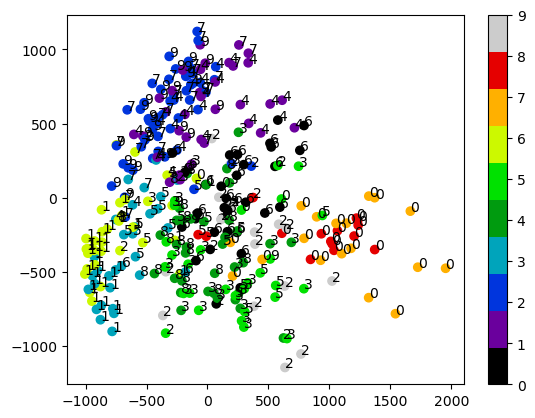

In [10]:
import matplotlib.pyplot as plt

samples = 300 # Número de instancias a dibujar
# Dibujar los puntos en el espacio, color: cluster, etiqueta-numérica: clase
# Color del punto: cluster
sc = plt.scatter(x_train_PCAspace[:samples,0],x_train_PCAspace[:samples,1], cmap=plt.cm.get_cmap('nipy_spectral', 10),c=kmeansLabels[:samples])
plt.colorbar()

# Etiqueta numérica: clase 
for i in range(samples):
    plt.text(x_train_PCAspace[i,0],x_train_PCAspace[i,1], y_train[i])

Como podemos observar en este gráfico, se han realizado 10 clusters, pero los labels asignados no se corresponden con las etiquetas reales de las imágenes. En el siguiente heatmap se relacionan los labels reales (el eje X) con los labels resultado del clustering (eje Y).

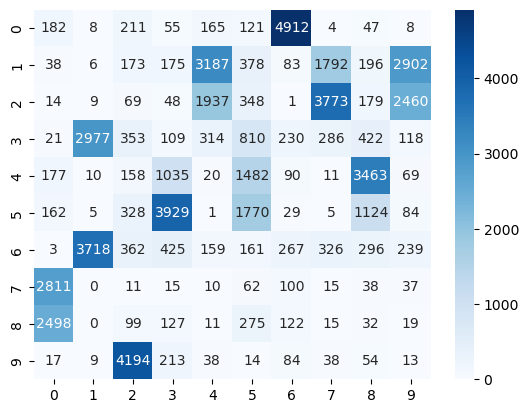

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# El atributo generado por K-means es int, hay que pasarlos a string
to_string = lambda x : str(x)
# Obtener matriz de confusión Class to clustering eval
cm = confusion_matrix(np.vectorize(to_string)(kmeansLabels), np.vectorize(to_string)(y_train))

# Mapa de calor a partir de la matriz de confusion
ax = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

Fijándonos, podemos obsevar que las imágenes que representan el número 2, por ejemplo, están clasificadas como el número 9, pero no existe ninguna otra clase que se relacione con el número 2 real. Esto nos indica que el clustering para el número 2 está muy bien identificado. Sin embargo, existe confusión en el número 0, pues tanto el cluster 7 como el 8 se agrupan sobre el mismo dígito. También podemos ver esto en el gráfico de colores anterior: las etiquetas 7 y 8 (naranja y rojo respectivamente) son dificilmente diferenciables.

**Reasignación de labels**

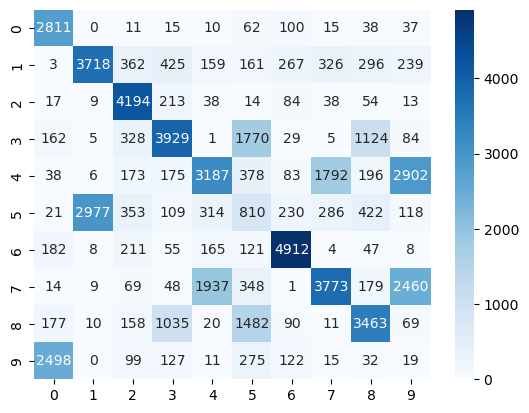

In [12]:
cm_new = [cm[7], cm[6], cm[9], cm[5], cm[1], cm[3], cm[0], cm[2], cm[4], cm[8]]
ax = sns.heatmap(cm_new, annot=True, cmap="Blues", fmt="d")

En esta reasignación, podemos ver que la matriz de confusión toma más sentido en la diagonal. Sin embargo, el 0 y el 9 no están muy bien diferenciados al igual que el 4 y el 9.

## Evaluación cuantitativa del clustering

**Silhouette scores**

Para evaluar la "calidad" del clustering final tenemos que evaluar la cohesión, o el grado en que se agrupan las instancias de un mismo cluster, y la separación entre distintos clusters. Por ello, vamos a emplear el método de Silhouette scores en el que se relaciona la separación y la cohesión de cada instancia.

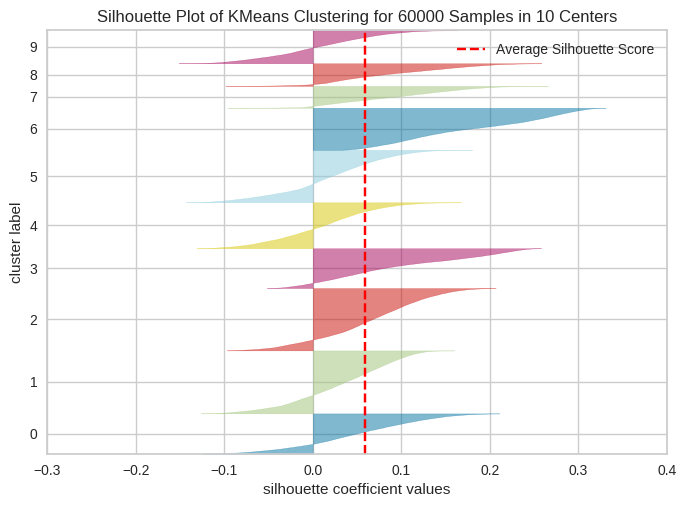

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fea59ab1240>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=10, n_init=10, random_state=0))

In [35]:
from yellowbrick.cluster import silhouette_visualizer

# No está acelerado por hardware. ¡Tarda mucho!
silhouette_visualizer(KMeans(n_clusters, n_init=n_inicializaciones, random_state=0), x_train, colors='yellowbrick')

## Selección del número de clusters

En este apartado vamos a estudiar dos formas de realizar la selección del número de clusters. La primera, consiste en el método del codo basado en medir la inercia sobre el modelo. Esta métrica consiste en la distancia acumulada entre cada punto a su centroide más cercano. La segunda, consiste en comparar los Silhouete scores de cada una de las iteraciones del cluster.

**Cálculo de inercias**

In [14]:
cluster_sizes = list(range(9, 25))
inertias = {}

for n in cluster_sizes:
    km = KMeans(n, n_init=n_inicializaciones, random_state=0)
    km.fit(x_train)
    inertia = km.inertia_
    inertias[n] = inertia

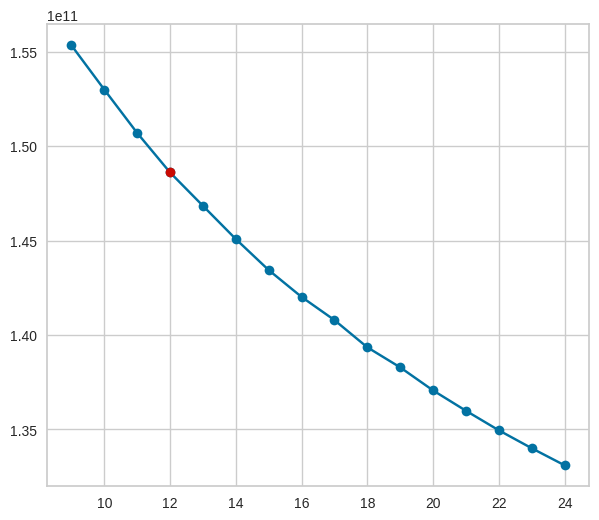

In [16]:
plt.figure(figsize=(7, 6))
plt.plot(list(inertias.keys()), list(inertias.values()), 'o-')
pointsx = [12]

for pointx in pointsx:
    inertia = inertias[pointx]
    plt.plot([pointx], [inertia], 'ro')


**Comparación de Silhouette scores**

In [17]:
from sklearn.metrics import silhouette_score
cluster_sizes = list(range(9, 13))
scores = {}

for n in cluster_sizes:
    # Creamos una instancia de k-means con n clusters
    km = KMeans(n, n_init=n_inicializaciones, random_state=0)
    km_labels = km.fit(x_train)

    # Calculamos el Silhouette score
    score = silhouette_score(x_train, km.labels_, metric='euclidean')
    scores[n] = score


<BarContainer object of 4 artists>

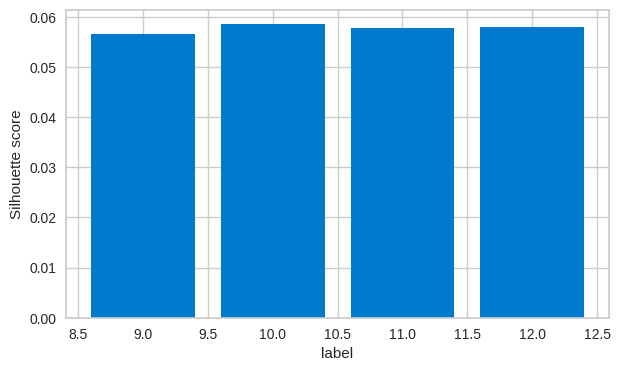

In [18]:
# Representamos los resultados en una gráfica de barras
fig, ax = plt.subplots(figsize=(7,4))
ax.set_xlabel('label')
ax.set_ylabel('Silhouette score')

plt.bar(scores.keys(), scores.values(), align='center', color='#007acc')

In [19]:
scores

{9: 0.05657226520015277,
 10: 0.0584891472941379,
 11: 0.05773243621015362,
 12: 0.0579687860489755}

Este método es muy ineficiente ya que hay que calcular todos los clusters y además evaluar la cohesión y separación de cada instancia. En conjuntos de datos con pocas features e instancias puede ser muy preciso, pero en un conjunto tan grande requiere de mucha capacidad de cómputo.

## Asignación de un cluster a una nueva instancia

In [81]:
convert("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte",
"mnist_test.csv", 10000)

In [20]:
# Cargamos una nueva instancia
test = pd.read_csv('mnist_test.csv')
y_test = test['label'].copy()
test.drop('label', axis=1, inplace=True)
x_test = test

label 0


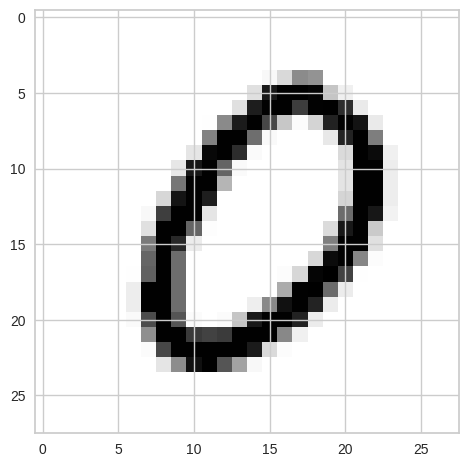

In [27]:
n_x = 794 # Índice de la instancia a seleccionar
visualize(n_x, x_test, y_test)

In [30]:
x = x_test.iloc[n_x].to_numpy().reshape(1, -1) # Seleccionamos la instancia
label = kmeans.predict(x)

print(f"El label estimado es: {label[0]}")

El label estimado es: 8


En este caso, el label estimado es 8 cuando realmente es un 0. Sin embargo, esto resulta porque Kmeans asigna labels aleatorios a los clusters. Su función no es la de estimar si una imagen es un número u otro, si no evaluar los datos y generar subconjuntos lo más diferenciados posibles. Por ello, si nos fijamos en el [heatmap 1](#Representación-de-los-clusters), podemos ver que realmente el label 8 estimado (eje y) se llega a corresponder con el número real 0 (eje x).

## Determinar la dimensión óptima de reducción

Para determinar la dimensión óptima de reducción vamos a recurrir a una métrica que expresa la concentración de información por componente: los eigenvalues. Si graficamos estos valores obtenemos lo que se denomina scree plot.

In [31]:
pca = PCA(n_components=20) # reducimos el espacio a una cantidad de dimensiones considerables para hacer el estudio
pca.fit(x_train)

PCA(n_components=20)

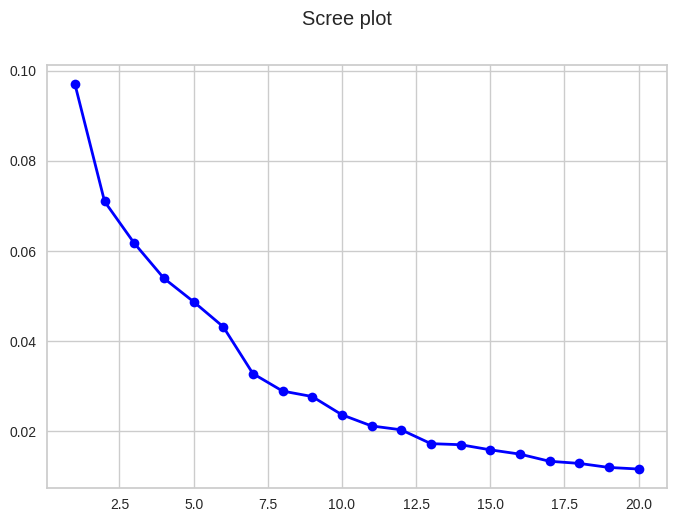

In [34]:
# función para graficar
def graph(ax, pca_t, color='blue'):
    PC_values = np.arange(pca_t.n_components_) + 1
    ax.plot(PC_values, pca_t.explained_variance_ratio_, 'o-', linewidth=2, color=color)

# Representamos las reducciones -> Eje X: dimensiones de reducción Eje Y: Eigenvalues (variación en los datos)
fig, (ax1) = plt.subplots(1)
fig.suptitle('Scree plot')

graph(ax1, pca)


Estas gráficas representan la concentración de información por cada una de las componentes. Como podemos observar, la mayor concentración de información se encuentra entre las dimensiones 1 y 10, por lo que 10 dimensiones proporcionará una cantidad adecuada de información para realizar el clustering.

## Reducción PCA y clustering

En esta sección vamos a hacer una comparativa entre realizar un clustering tomando el conjunto completo de los datos o aplicar una reducción de dimensiones y luego aplicar el clustering.

In [5]:
# Resultados clustering con 784 features y 60000 instancias

from sklearn.metrics import silhouette_score
silhouette_score(x_train, kmeans.labels_, metric='euclidean')

0.0584891472941379

In [7]:
# Resultados PCA + clustering (10 features y 60000 instancias)
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(x_train)
# Cambio de base a 10 dimensiones PCA 
x_train_PCAspace = pca.transform(x_train)

n_clusters = 10 # Número de labels o clusters a crear sobre el conjunto de datos
n_inicializaciones = 10 # Número de inicializaciones con diferentes centroides aleatorios

kmeans = KMeans(n_clusters, n_init=n_inicializaciones, random_state=0)
kmeans.fit(x_train_PCAspace)

silhouette_score(x_train_PCAspace, kmeans.labels_, metric='euclidean')

0.16945959474548994

Como podemos ver, haciendo una reducción del espacio a 10 dimensiones (10 features) obtenemos un mejor resultado que empleando las 784 iniciales.

# Respuestas

**1. ¿Con el clustering, en qué medida se agrupan las imágenes de los mismos dígitos dentro del mismo cluster?**

Para medir en qué medida se agrupan los elementos de un mismo cluster podemos recurrir a la cohesión, para obtener una medida cuantitativa, o a una matriz de confusión, que nos indica la dispersión de los elementos de una forma gráfica. Estas opciones están estudiadas en los apartados [Representación](#Representación-de-los-clusters) y [Evaluación](#Evaluación-cuantitativa-del-clustering).

**2. ¿pruebo sólo 10 clusters o podría obtener clusters más puros empleando otro número de clusters?**

Ver [Selección del número de clusters](#Selección-del-número-de-clusters)

**3. ¿Conviene hacer el clustering antes/después de reducir la dimensión del espacio?**

Ver [Reducción](#Reducción-PCA-y-clustering)

**4. ¿Cuál es la dimensión del espacio que mejor calidad ofrece?**

Ver [Dimensión óptima de reducción](#Determinar-la-dimensión-óptima-de-reducción)

**5. ¿Cómo asigno una nueva imagen a uno de los clusters previamente generado?**

Para asignar una nueva instancia a un cluster hay que calcular la suma de las distancias entre el centroide de cada cluster y la instancia a evaluar. En la sección [Asignación](#Asignación-de-un-cluster-a-una-nueva-instancia) he hecho uso de la función ya implementada *predict(X)*.

**6. Métricas alternativas para evaluar la calidad obtenida**

En la sección [Evaluación](#Evaluación-cuantitativa-del-clustering) realizo un estudio sobre la métrica Silhouette. Métrica que establece una relación entre la separabilidad y la cohesión de los clusters. En la sección [Selección](#Selección-del-número-de-clusters) muestro cómo aplicar esta métrica en la selección del número de clusters.